In [1]:
import re
import os
import gc
import json
import fiona
import shutil
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
from pathlib import Path
from osgeo import gdal, osr
import dask_geopandas as dgpd
from shapely.geometry import shape
from rasterstats import zonal_stats
from shapely.wkt import loads
import geopandas as gpd
import fiona

BASE_DIR = Path('/Users/wenlanzhang/PycharmProjects/Mapineq/src/data-wrangling/')
DATA_DIR = Path('/Users/wenlanzhang/Downloads/PhD_UCL/Data/Oxford')

In [2]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

**Default**:  

CRS: EPSG:27700  
2021: ITL1: 12 rows | ITL2: 41 rows | ITL3: 179 rows  
total: 232  
2025: ITL1: 12 rows | ITL2: 46 rows | ITL3: 182 rows  
total: 240  

---

**This code**: 
1. Read in 3 level and add a column 'ITL_LEVEL' == 1,2,3  
2. combine 3 level
3. unite column name
4. export as .shp + .geojson

# 2021

<Axes: >

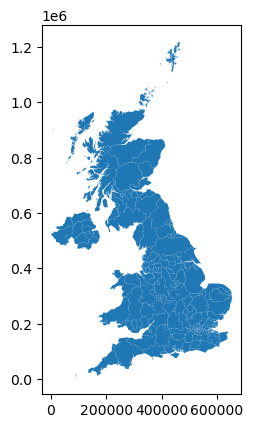

In [2]:
# Level 1
file_1 = DATA_DIR / 'ITL/2021_BGC/International_Territorial_Level_1_January_2021_UK_BGC_2022_-7141730263928228448.gpkg'
gdf_1 = gpd.read_file(file_1, layer=fiona.listlayers(file_1)[0])
gdf_1['ITL_LEVEL'] = 1

# Level 2
file_2 = DATA_DIR / 'ITL/2021_BGC/International_Territorial_Level_2_January_2021_UK_BGC_V2_2022_-6393280670922287483.gpkg'
gdf_2 = gpd.read_file(file_2, layer=fiona.listlayers(file_2)[0])
gdf_2['ITL_LEVEL'] = 2

# Level 3
file_3 = DATA_DIR / 'ITL/2021_BGC/International_Territorial_Level_3_January_2021_UK_BGC_V3_2022_-5900518147011624330.gpkg'
gdf_3 = gpd.read_file(file_3, layer=fiona.listlayers(file_3)[0])
gdf_3['ITL_LEVEL'] = 3
gdf_3.plot()

In [3]:
# --- Check CRS ---
print("Level 1 CRS:", gdf_1.crs)
print("Level 2 CRS:", gdf_2.crs)
print("Level 3 CRS:", gdf_3.crs)

# Compare them
print("All CRS match:",
      (gdf_1.crs == gdf_2.crs == gdf_3.crs))

Level 1 CRS: EPSG:27700
Level 2 CRS: EPSG:27700
Level 3 CRS: EPSG:27700
All CRS match: True


In [4]:
# Consistent column names
def standardize_itl_columns(gdf):
    # Find code and name columns dynamically
    code_col = [col for col in gdf.columns if col.startswith("ITL") and col.endswith("CD")]
    name_col = [col for col in gdf.columns if col.startswith("ITL") and col.endswith("NM")]

    if code_col and name_col:
        gdf = gdf.rename(columns={
            code_col[0]: "ITL_CODE",
            name_col[0]: "ITL_NAME"
        })
    else:
        print("⚠️ Could not find ITL code/name columns.")
    
    return gdf

gdf_1 = standardize_itl_columns(gdf_1)
gdf_2 = standardize_itl_columns(gdf_2)
gdf_3 = standardize_itl_columns(gdf_3)
gdf_1

,ITL_CODE,ITL_NAME,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,ITL_LEVEL
0,TLC,North East (England),417314,600356,-1.728880,55.297009,{E410113B-5526-493F-B7E5-6C8F53332617},"MULTIPOLYGON (((402039.597 506235.701, 402144....",1
1,TLD,North West (England),350014,506279,-2.772390,54.449440,{2BCF98A1-8BD8-491A-9627-1BFC6391D1E3},"MULTIPOLYGON (((364516.901 338994.103, 364533....",1
2,TLE,Yorkshire and The Humber,446902,448736,-1.287140,53.932640,{D10DC201-3DB7-4A7E-918E-B7E65831B3C8},"MULTIPOLYGON (((450524.201 378564.296, 450641....",1
3,TLF,East Midlands (England),477659,322635,-0.849690,52.795719,{3B83CF4F-DB85-48A4-8D99-C4856F5FD18F},"MULTIPOLYGON (((455182.298 231283.095, 455301....",1
4,TLG,West Midlands (England),386294,295477,-2.203580,52.556969,{1E0E7984-20AF-4BD3-A1AE-D3039631CAB2},"MULTIPOLYGON (((403387.797 368314.9, 402988.2 ...",1
5,TLH,East,571078,263235,0.504207,52.240730,{4B1BA87B-D11E-4DC3-9A25-1A0CB716C7C4},"MULTIPOLYGON (((564008.6 175098.15, 564475.15 ...",1
6,TLI,London,517515,178392,-0.308660,51.492271,{69301F44-B650-4D5F-B49D-C0CD83C03B4D},"MULTIPOLYGON (((530898.104 155850.797, 531351....",1
7,TLJ,South East (England),470062,172924,-0.993110,51.450970,{8A000D13-E10F-4135-B349-37733FBAA7AC},"MULTIPOLYGON (((421792.665 93133.423, 421856.0...",1
8,TLK,South West (England),285013,102567,-3.633460,50.811192,{E03D492E-DEF7-4F9D-91C6-352E477BF951},"MULTIPOLYGON (((170406.03 11429.67, 170425.23 ...",1
9,TLL,Wales,263405,242881,-3.994170,52.067410,{B58A7D62-AA8D-4568-BCE7-1B0017C9BC44},"MULTIPOLYGON (((306738.008 165524.619, 307334....",1


In [5]:
# Convert column names to sets (ignores order)
cols_1 = set(gdf_1.columns)
cols_2 = set(gdf_2.columns)
cols_3 = set(gdf_3.columns)

# Check pairwise equality
print("gdf_1 vs gdf_2:", cols_1 == cols_2)
print("gdf_2 vs gdf_3:", cols_2 == cols_3)
print("gdf_1 vs gdf_3:", cols_1 == cols_3)

print(f"ITL1: {len(gdf_1)} rows | ITL2: {len(gdf_2)} rows | ITL3: {len(gdf_3)} rows")

gdf_1 vs gdf_2: True
gdf_2 vs gdf_3: True
gdf_1 vs gdf_3: True
ITL1: 12 rows | ITL2: 41 rows | ITL3: 179 rows


In [6]:
# Combine them vertically
gdf_all = gpd.GeoDataFrame(
    pd.concat([gdf_1, gdf_2, gdf_3], ignore_index=True),
    crs=gdf_1.crs  # Assuming all share the same CRS
)
gdf_all

,ITL_CODE,ITL_NAME,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,ITL_LEVEL
0,TLC,North East (England),417314,600356,-1.72888,55.297009,{E410113B-5526-493F-B7E5-6C8F53332617},"MULTIPOLYGON (((402039.597 506235.701, 402144....",1
1,TLD,North West (England),350014,506279,-2.77239,54.449440,{2BCF98A1-8BD8-491A-9627-1BFC6391D1E3},"MULTIPOLYGON (((364516.901 338994.103, 364533....",1
2,TLE,Yorkshire and The Humber,446902,448736,-1.28714,53.932640,{D10DC201-3DB7-4A7E-918E-B7E65831B3C8},"MULTIPOLYGON (((450524.201 378564.296, 450641....",1
3,TLF,East Midlands (England),477659,322635,-0.84969,52.795719,{3B83CF4F-DB85-48A4-8D99-C4856F5FD18F},"MULTIPOLYGON (((455182.298 231283.095, 455301....",1
4,TLG,West Midlands (England),386294,295477,-2.20358,52.556969,{1E0E7984-20AF-4BD3-A1AE-D3039631CAB2},"MULTIPOLYGON (((403387.797 368314.9, 402988.2 ...",1
...,...,...,...,...,...,...,...,...,...
227,TLN0E,Lisburn and Castlereagh,138776,518906,-6.03445,54.497429,{50721677-A22E-4B20-91B2-78903723044D},"MULTIPOLYGON (((138843.75 530937.408, 138732.1...",3
228,TLN0F,Mid and East Antrim,134007,560141,-6.14545,54.864559,{128EF1A0-CC2E-4C8B-B9C1-1190AFF68C08},"MULTIPOLYGON (((112237.347 552083.778, 113232....",3
229,TLN0G,Fermanagh and Omagh,41284,512998,-7.52630,54.385109,{8DFCA385-0F24-454A-B0AA-0512B9E9C73F},"MULTIPOLYGON (((80027.441 554144.198, 79912.33...",3
230,TLK24,"Bournemouth, Christchurch and Poole",410815,94066,-1.84807,50.746090,{FA4DFE27-A134-4841-B551-2F91C2EAA33A},"MULTIPOLYGON (((403839.945 87004.556, 403846.8...",3


In [7]:
shapefile_path = DATA_DIR / "ITL/itl_2021_BGC.shp"

# Save GeoDataFrame to shapefile
gdf_all.to_file(shapefile_path)

# 2025

<Axes: >

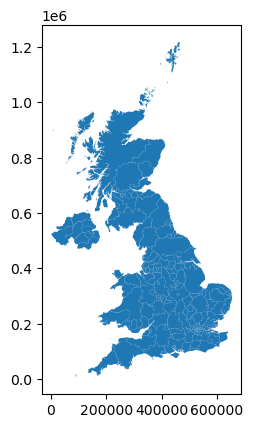

In [8]:
# Level 1
file_1 = DATA_DIR / 'ITL/2025_BGC/ITL1_JAN_2025_UK_BGC.shp'
gdf_1 = gpd.read_file(file_1, layer=fiona.listlayers(file_1)[0])
gdf_1['ITL_LEVEL'] = 1

# Level 2
file_2 = DATA_DIR / 'ITL/2025_BGC/ITL2_JAN_2025_UK_BGC_-2877193738657512356.gpkg'
gdf_2 = gpd.read_file(file_2, layer=fiona.listlayers(file_2)[0])
gdf_2['ITL_LEVEL'] = 2

# Level 3
file_3 = DATA_DIR / 'ITL/2025_BGC/International_Territorial_Level_3_(January_2025)_Boundaries_UK_BGC_V2.shp'
gdf_3 = gpd.read_file(file_3)
gdf_3 = gdf_3.drop(columns=['FID', 'Shape__Are', 'Shape__Len'])
gdf_3['ITL_LEVEL'] = 3

gdf_3.plot()

In [10]:
# Convert column names to sets (ignores order)
cols_1 = set(gdf_1.columns)
cols_2 = set(gdf_2.columns)
cols_3 = set(gdf_3.columns)

# Check pairwise equality
print("gdf_1 vs gdf_2:", cols_1 == cols_2)
print("gdf_2 vs gdf_3:", cols_2 == cols_3)
print("gdf_1 vs gdf_3:", cols_1 == cols_3)

print(f"ITL1: {len(gdf_1)} rows | ITL2: {len(gdf_2)} rows | ITL3: {len(gdf_3)} rows")

gdf_1 vs gdf_2: False
gdf_2 vs gdf_3: False
gdf_1 vs gdf_3: False
ITL1: 12 rows | ITL2: 46 rows | ITL3: 182 rows


In [12]:
# Consistent column names
def standardize_itl_columns(gdf):
    # Find code and name columns dynamically
    code_col = [col for col in gdf.columns if col.startswith("ITL") and col.endswith("CD")]
    name_col = [col for col in gdf.columns if col.startswith("ITL") and col.endswith("NM")]

    if code_col and name_col:
        gdf = gdf.rename(columns={
            code_col[0]: "ITL_CODE",
            name_col[0]: "ITL_NAME"
        })
    else:
        print("⚠️ Could not find ITL code/name columns.")
    
    return gdf

gdf_1 = standardize_itl_columns(gdf_1)
gdf_2 = standardize_itl_columns(gdf_2)
gdf_3 = standardize_itl_columns(gdf_3)
gdf_1

,ITL_CODE,ITL_NAME,BNG_E,BNG_N,LAT,LONG,GlobalID,geometry,ITL_LEVEL
0,TLC,North East (England),417317.0,575393.0,55.07271,-1.730360,64e59e2d-3d6e-435f-87f7-67a45ac92753,"MULTIPOLYGON (((450272 525912.8, 450135.8 5258...",1
1,TLD,North West (England),349989.0,463422.0,54.06431,-2.765600,bbf6fc7f-ef09-412a-8146-09b7012a8cbe,"MULTIPOLYGON (((327839.851 373746.127, 327859....",1
2,TLE,Yorkshire and The Humber,452737.0,445838.0,53.90604,-1.198780,92e88583-d82d-4b6b-9a1e-61fc408945f0,"MULTIPOLYGON (((495485.797 422529.602, 496086....",1
3,TLF,East Midlands (England),477748.0,322635.0,52.79571,-0.848370,7228a5bc-2e4d-4582-a137-59b0f4bf1b1e,"MULTIPOLYGON (((552995.402 326666.551, 552916....",1
4,TLG,West Midlands (England),386293.0,295477.0,52.55697,-2.203600,65bb5e9c-802f-4ae7-9d48-e3d79e9ddfef,"POLYGON ((445790.299 252455.405, 445710 252328...",1
5,TLH,East (England),571245.0,262605.0,52.23502,0.506332,e93f2634-e439-4e89-8342-9c4a2435c508,"MULTIPOLYGON (((570606.94 181367.87, 570558.36...",1
6,TLI,London,529614.0,178394.0,51.48965,-0.134480,a79119aa-3c98-47b7-b51f-568f3e9f142e,"MULTIPOLYGON (((516084.973 172495.06, 516122.6...",1
7,TLJ,South East (England),470064.0,172924.0,51.45098,-0.993090,f47200b7-43f8-4342-92a4-61d8c30ea289,"MULTIPOLYGON (((429002.998 84817.937, 428968.9...",1
8,TLK,South West (England),333577.0,128616.0,51.05302,-2.949050,e34faa01-0e5a-4309-8b41-c0acd24c099a,"MULTIPOLYGON (((83999.7 5358.6, 83889.79 5352....",1
9,TLL,Wales,263397.0,283889.0,52.43587,-4.010890,ee730b9a-2f25-4dfe-b205-9b1ee4153803,"MULTIPOLYGON (((322311.497 164638.802, 322288....",1


In [13]:
# Combine them vertically
gdf_all = gpd.GeoDataFrame(
    pd.concat([gdf_1, gdf_2, gdf_3], ignore_index=True),
    crs=gdf_1.crs  # Assuming all share the same CRS
)
gdf_all

,ITL_CODE,ITL_NAME,BNG_E,BNG_N,LAT,LONG,GlobalID,geometry,ITL_LEVEL
0,TLC,North East (England),417317.0,575393.0,55.07271,-1.73036,64e59e2d-3d6e-435f-87f7-67a45ac92753,"MULTIPOLYGON (((450272 525912.8, 450135.8 5258...",1
1,TLD,North West (England),349989.0,463422.0,54.06431,-2.76560,bbf6fc7f-ef09-412a-8146-09b7012a8cbe,"MULTIPOLYGON (((327839.851 373746.127, 327859....",1
2,TLE,Yorkshire and The Humber,452737.0,445838.0,53.90604,-1.19878,92e88583-d82d-4b6b-9a1e-61fc408945f0,"MULTIPOLYGON (((495485.797 422529.602, 496086....",1
3,TLF,East Midlands (England),477748.0,322635.0,52.79571,-0.84837,7228a5bc-2e4d-4582-a137-59b0f4bf1b1e,"MULTIPOLYGON (((552995.402 326666.551, 552916....",1
4,TLG,West Midlands (England),386293.0,295477.0,52.55697,-2.20360,65bb5e9c-802f-4ae7-9d48-e3d79e9ddfef,"POLYGON ((445790.299 252455.405, 445710 252328...",1
...,...,...,...,...,...,...,...,...,...
235,TLN0C,Causeway Coast and Glens,106168.0,581420.0,55.03962,-6.59961,62357ce7-5175-4926-89f5-4b65ac80c9b0,"MULTIPOLYGON (((115243.198 604471.389, 115367....",3
236,TLN0D,Antrim and Newtownabbey,130813.0,541285.0,54.69386,-6.17760,5fb3624b-993f-40f2-be24-137233de823a,"POLYGON ((150729.398 539530.507, 150424.412 53...",3
237,TLN0E,Lisburn and Castlereagh,138712.0,518920.0,54.49753,-6.03545,e63f0072-cf80-4bd0-a724-1b4f2dda28d5,"POLYGON ((138779.563 530950.247, 138812.152 53...",3
238,TLN0F,Mid and East Antrim,133943.0,560151.0,54.86462,-6.14646,3ef91bbe-b445-46fd-b1cc-912f21a550df,"POLYGON ((150729.398 539530.507, 150726.768 53...",3


In [14]:
shapefile_path = DATA_DIR / "ITL/itl_2025_BGC.shp"

# Save GeoDataFrame to shapefile
gdf_all.to_file(shapefile_path)

# Get Bbox boudary for each

In [18]:
# Paths to your shapefiles — replace these with actual file paths
itl_2021_path = DATA_DIR/"ITL/itl_2021_BGC.shp"
itl_2025_path = DATA_DIR/"ITL/itl_2025_BGC.shp"

# Read the shapefiles
itl_2021 = gpd.read_file(itl_2021_path)
itl_2025 = gpd.read_file(itl_2025_path)

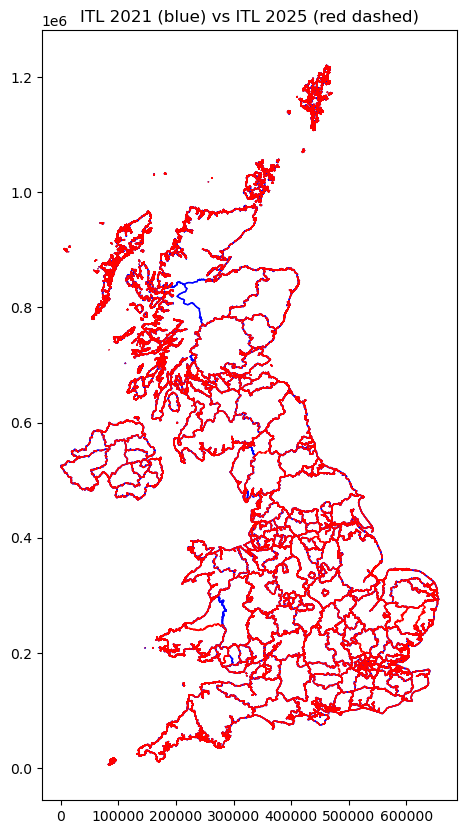

In [19]:
import matplotlib.pyplot as plt
from shapely.geometry import box

# Optional: reproject to match if needed
if itl_2021.crs != itl_2025.crs:
    itl_2025 = itl_2025.to_crs(itl_2021.crs)

# Plot both shapefiles
fig, ax = plt.subplots(figsize=(10, 10))
itl_2021.plot(ax=ax, edgecolor='blue', facecolor='none', label='ITL 2021')
itl_2025.plot(ax=ax, edgecolor='red', facecolor='none', linestyle='--', label='ITL 2025')
# plt.legend()
plt.title("ITL 2021 (blue) vs ITL 2025 (red dashed)")
plt.show()

In [20]:
# Generate bounding boxes
bbox_2021 = box(*itl_2021.total_bounds)
bbox_2025 = box(*itl_2025.total_bounds)

# Wrap each box in a GeoDataFrame
bbox_gdf_2021 = gpd.GeoDataFrame(geometry=[bbox_2021], crs=itl_2021.crs)
bbox_gdf_2025 = gpd.GeoDataFrame(geometry=[bbox_2025], crs=itl_2025.crs)

# Optional: print or export
print("Bounding box 2021:", bbox_2021.bounds)
print("Bounding box 2025:", bbox_2025.bounds)

Bounding box 2021: (-116.19280000030994, 5342.699799999595, 655653.8499999996, 1220301.5020000003)
Bounding box 2025: (-116.19280000031, 5352.5999999996275, 655653.85, 1220299.4698)


In [22]:
# # Optional: save to shapefiles
# bbox_gdf_2021.to_file(DATA_DIR/"ITL/bounding_box_ITL2021.shp")
# bbox_gdf_2025.to_file(DATA_DIR/"ITL/bounding_box_ITL2025.shp")

# Geojson to shp (Daniel)

In [17]:
# Load the GeoJSON file into a GeoDataFrame
try:
    gdf = gpd.read_file('/Users/wenlanzhang/Downloads/D_shp/euro2025_equal_earth_high_res.geojson')
    print("Successfully read the GeoJSON file!")
    print(gdf.head())  # Prints the first 5 rows of the GeoDataFrame
except Exception as e:
    print(f"Error reading the file: {e}")

Successfully read the GeoJSON file!
  nuts_id  levl_code cntr_code                 name_latn  \
0     TLC          1        UK      North East (England)   
1     TLD          1        UK      North West (England)   
2     TLE          1        UK  Yorkshire and The Humber   
3     TLF          1        UK   East Midlands (England)   
4     TLG          1        UK   West Midlands (England)   

                  nuts_name                                           geometry  
0      North East (England)  MULTIPOLYGON (((-92978.244 6438073.353, -93139...  
1      North West (England)  MULTIPOLYGON (((-237283.138 6307174.854, -2372...  
2  Yorkshire and The Humber  MULTIPOLYGON (((-42588.416 6348995.271, -41892...  
3   East Midlands (England)  MULTIPOLYGON (((20763.876 6264580.998, 20663.2...  
4   West Midlands (England)  MULTIPOLYGON (((-103474.783 6201426.304, -1035...  


In [18]:
gdf

,nuts_id,levl_code,cntr_code,name_latn,nuts_name,geometry
0,TLC,1,UK,North East (England),North East (England),"MULTIPOLYGON (((-92978.244 6438073.353, -93139..."
1,TLD,1,UK,North West (England),North West (England),"MULTIPOLYGON (((-237283.138 6307174.854, -2372..."
2,TLE,1,UK,Yorkshire and The Humber,Yorkshire and The Humber,"MULTIPOLYGON (((-42588.416 6348995.271, -41892..."
3,TLF,1,UK,East Midlands (England),East Midlands (England),"MULTIPOLYGON (((20763.876 6264580.998, 20663.2..."
4,TLG,1,UK,West Midlands (England),West Midlands (England),"MULTIPOLYGON (((-103474.783 6201426.304, -1035..."
...,...,...,...,...,...,...
2035,RO,0,RO,România,România,"MULTIPOLYGON (((5550240.663 2933328.113, 55511..."
2036,NO,0,NO,Norge,Norge,"MULTIPOLYGON (((4962846.066 5411852.375, 49628..."
2037,PL,0,PL,Polska,Polska,"MULTIPOLYGON (((4852825.195 3556096.333, 48551..."
2038,PT,0,PT,Portugal,Portugal,"MULTIPOLYGON (((2828494.611 2296190.204, 28279..."


In [19]:
# gdf['cntr_code'].unique()
df = gdf[(gdf['cntr_code'] == 'UK') & (gdf['levl_code'] == 0)]
df

,nuts_id,levl_code,cntr_code,name_latn,nuts_name,geometry
240,UK,0,UK,United Kingdom,United Kingdom,"MULTIPOLYGON (((-547495.509 6410366.501, -5474..."
241,UK_ITL,0,UK,United Kingdom,United Kingdom,"MULTIPOLYGON (((-547495.509 6410366.501, -5474..."


In [12]:
print(gdf.crs)

EPSG:8857


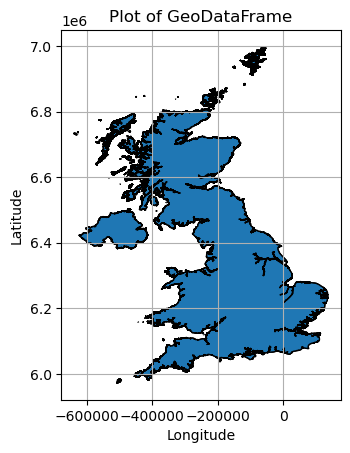

In [13]:
# Plot the GeoDataFrame
df.plot(edgecolor='black', linewidth=1)
plt.title('Plot of GeoDataFrame')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show() # to show the plot

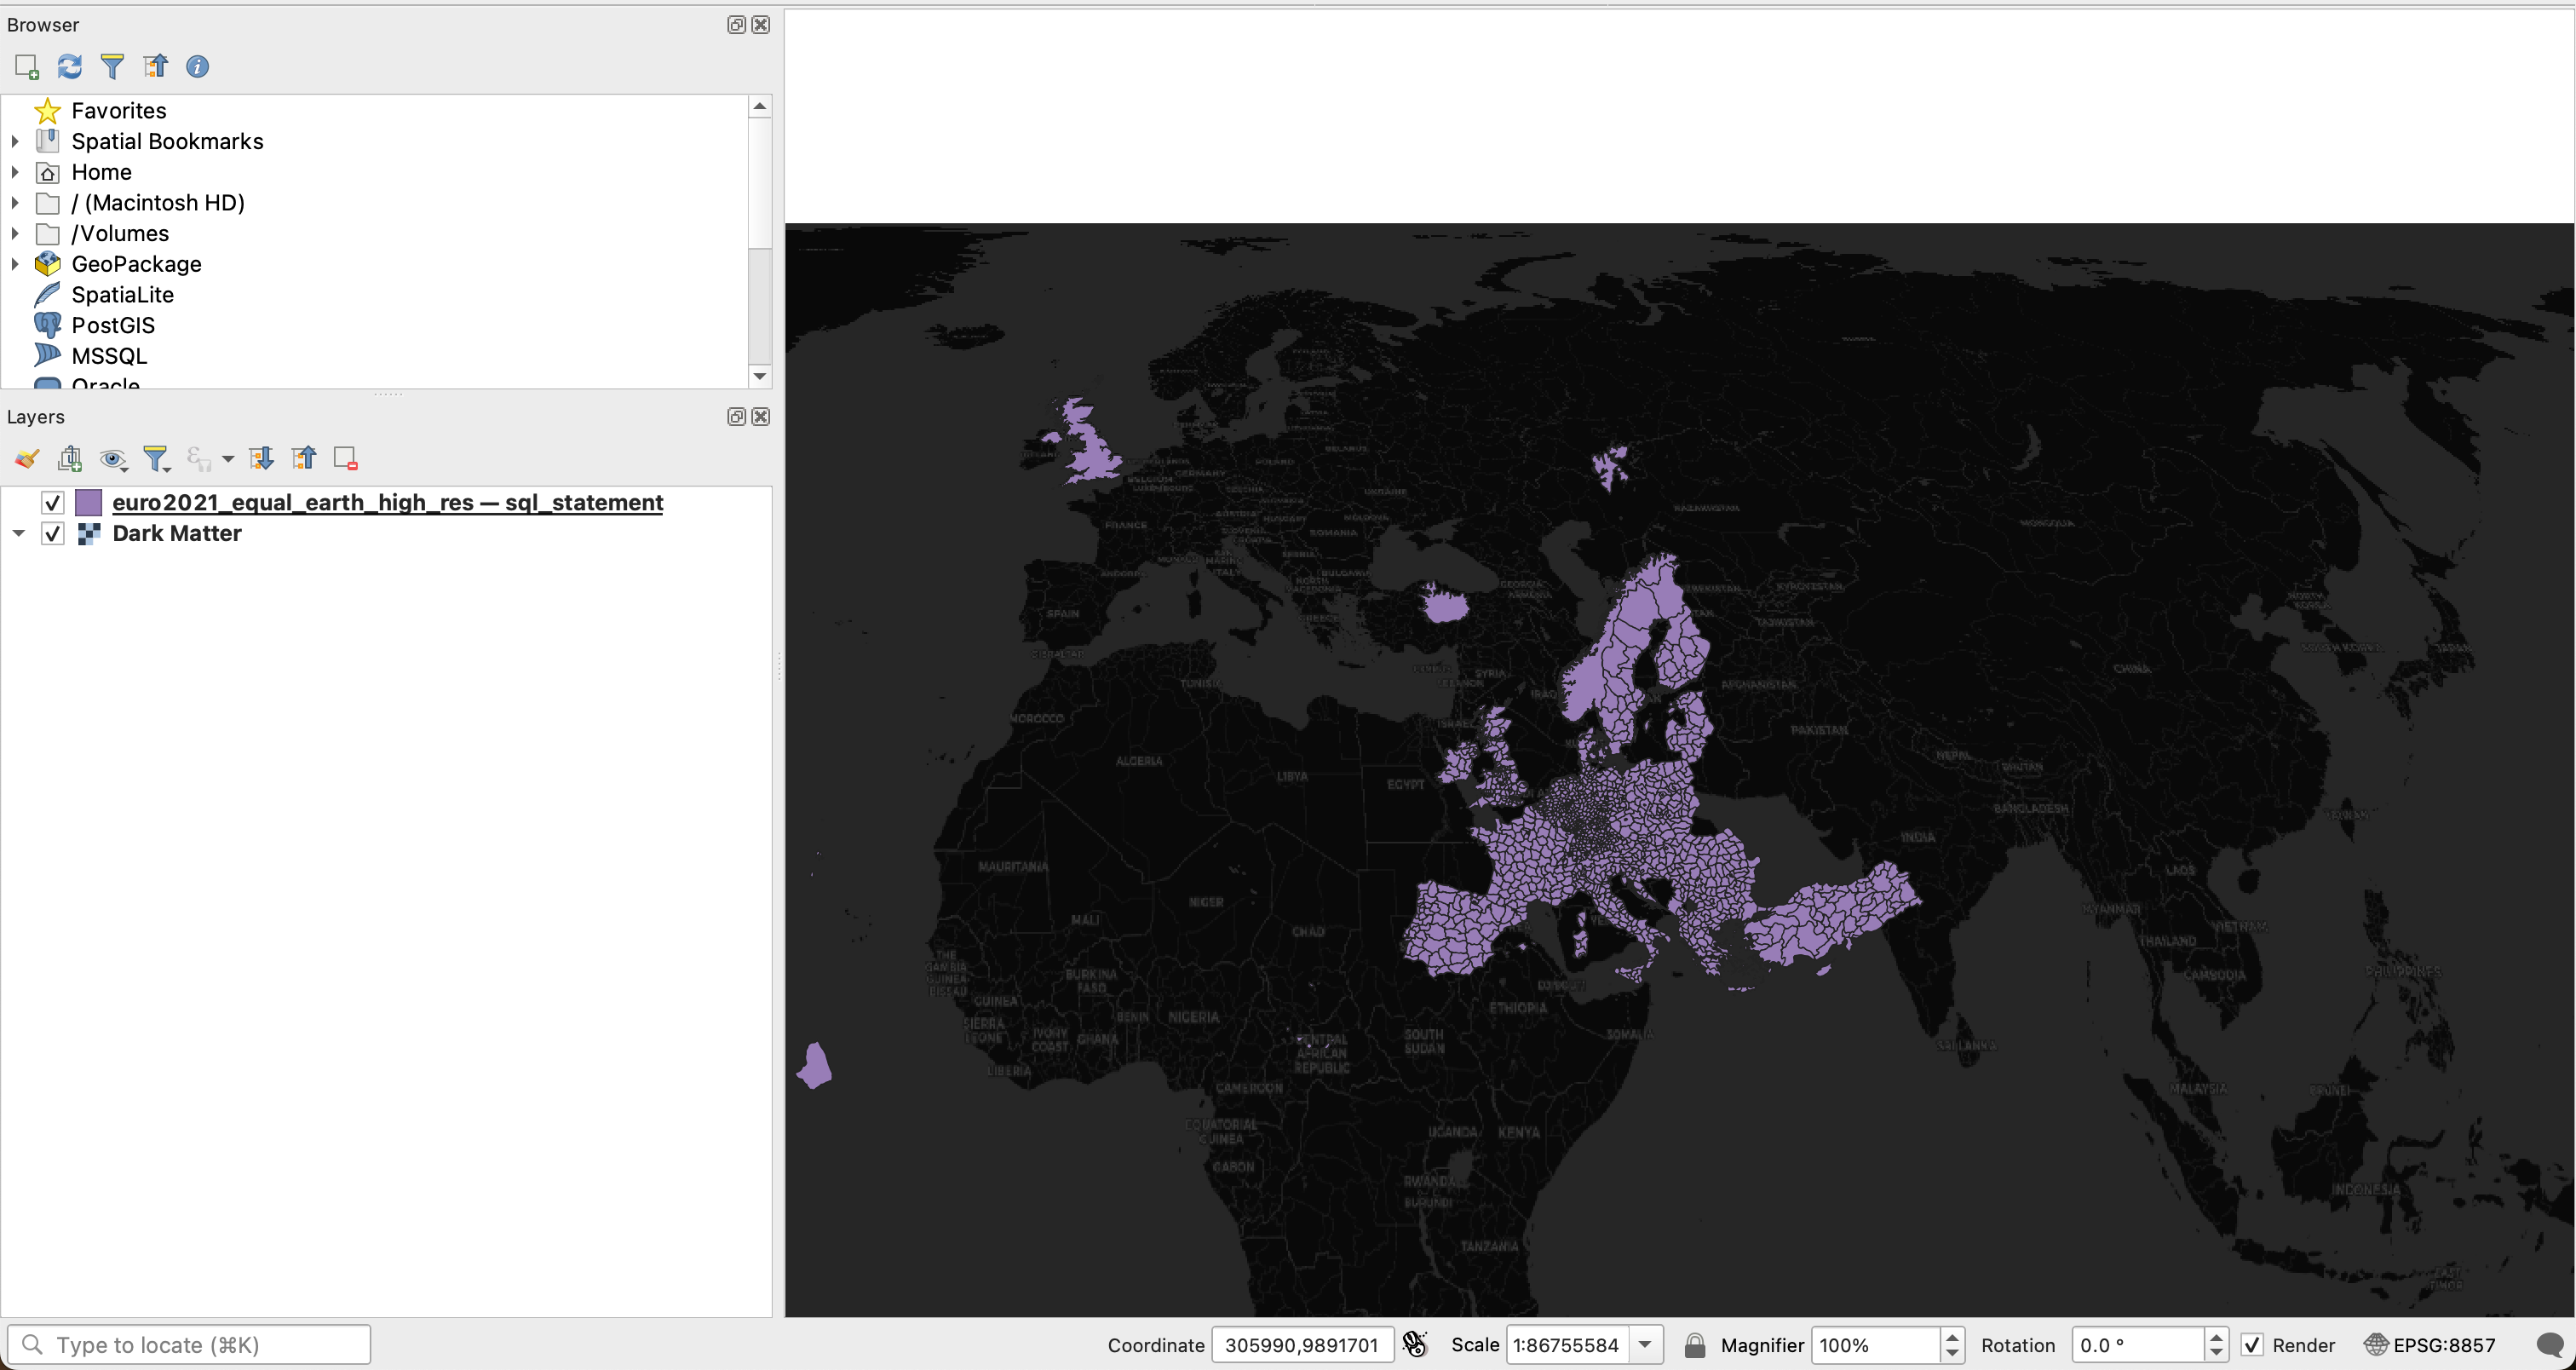

row more than expected